Tommaso Peritore

In [1]:
#matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as mcolors

#numpy
import numpy as np

#fit
from scipy.optimize import curve_fit
from scipy.stats import chi2, norm, cauchy

#center graphs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Exercise 2

## 2.1

Compute the following 1D integral via Monte Carlo 
$$I = \int_0^1 \frac{\pi}{2}\cos(\pi x/2) dx = 1$$

1. sampling a uniform distribution in $[0,1]$
2. using importance sampling (i.e. sampling a non-uniform probability in $[0,1]$)

Show a picture of both your estimations of $I$ and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$

## Solution

The calculation of a 1D integral via Monte Carlo requires the implementation of an Integral evaluator and some way to handle functions. In the course _Trattamento Numero di Dati Sperimentali_ we implemented a structure for integrals that I adapted to work in this context but from which I inherited the basic concept and architecture. Here is its basic functioning.

The file `functions.h` defines the parent class of a generic function, which contains the method 
````cpp
virtual double Evaluate (double x)
`````
to evaluate the function in a specific input value of $x$. 

The file `integral.h` defines the Integral class with a default constructor 
````cpp
Integral::Integral (double a, double b, Functions* f, Random* rnd)
`````
which takes in the limits of the integral (a and b) the function to be integrated and the random generator. 

Now for the two methods to calculate the integral, I will add a specific method to sample with uniform distribution and with importance sampling 
````cpp
double Integral::arithAverage(unsigned int N)
double Integral::impSampling(unsigned int N, Functions *p, Functions *inv_p)
`````
and I will explain later what each argument represents.

Both points of the exercise are executed in the file `main.cpp` and output their data in `2.1.*.dat`. 

### Uniform distribution

The evaluation of the given integral throgh uniform distribution sampling was pretty straight forward at this point. Having defined the classes needed, I initalized the cosine function as a child class of the parent function class mentioned above. With the cosine function being $a\cos(bx+c)$, I defined it with the parameters
````cpp
Cosine* cosine = new Cosine(M_PI / 2., M_PI / 2., 0.);
`````
which then allowed me to pass it as the argument for the initialization of the integral (defined from $0$ to $1$).
````cpp
Integral* integral = new Integral(0, 1, cosine, rnd);
````

Now each step inside the usual cycles for block averaging simply required to evaluate the integral using the method `arithAverage`. The latter uses the `Evaluate` method acting upon the function of the integral (i.e. our cosine function) evaluating it in a random value of $x$ generated within the limits of the integral. The progressive sum of the evaluations is saved so that after `blockSize` steps the integral is renormalized and moltiplied by its sign. 

The progressive data with relative errors is saved in the file `2.1.1.dat` and is shown below.

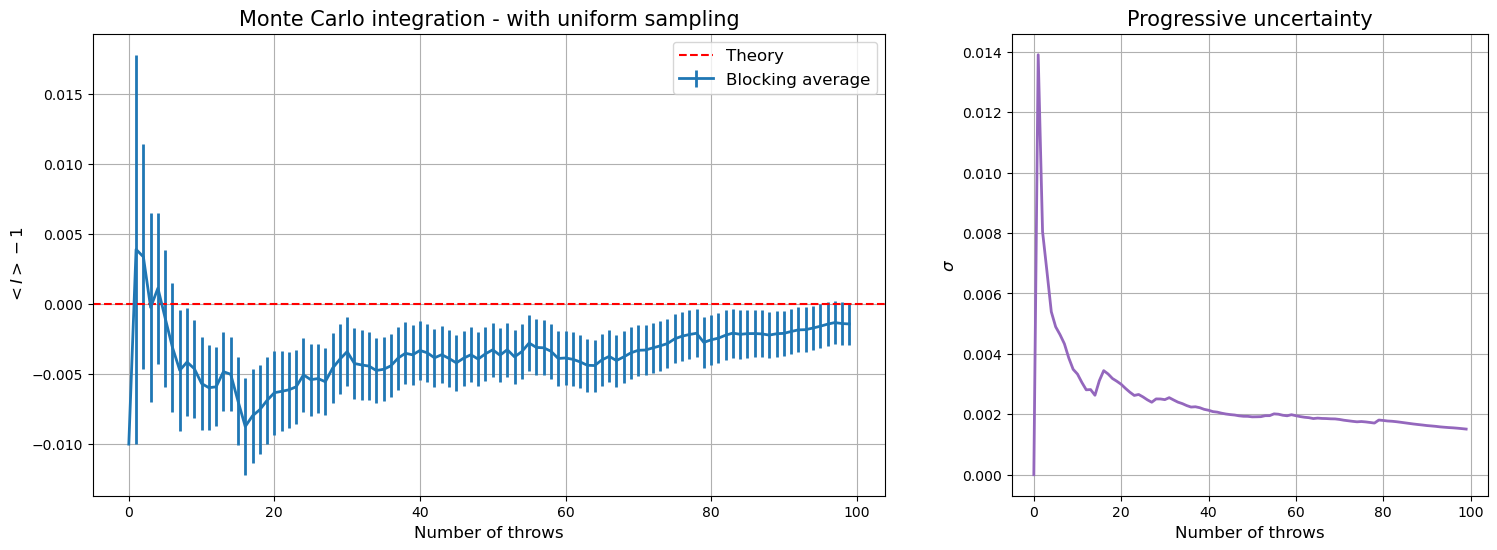

In [2]:
# uniform distribution data
x_valueU, progressive_averageU, progressive_errorU = np.loadtxt('2.1/2.1.1.dat', unpack=True, usecols=(0, 1, 2))

# Create a figure with 2 subplots, using width ratios of [2, 1.3] for the subplots
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [2, 1.2]}, figsize=(18,6))

# Plot data in the first subplot
axs[0].errorbar(x_valueU, progressive_averageU-1, yerr=progressive_errorU,lw=2, label='Blocking average', c='tab:blue')
axs[0].grid(True)  # Add grid lines to the plot
axs[0].axhline(0, ls='--', c='red', label='Theory')  # Add a horizontal line at y=0 in red
axs[0].set_xlabel('Number of throws', fontsize=12)
axs[0].set_ylabel('$<I>-1$', fontsize=12)
axs[0].legend(fontsize=12)  # Add a legend to the plot
axs[0].set_title('Monte Carlo integration - with uniform sampling', fontsize=15)

# Plot data in the second subplot
axs[1].plot(x_valueU, progressive_errorU,lw=2, c='tab:purple')
axs[1].grid(True)  # Add grid lines to the plot
axs[1].set_xlabel('Number of throws', fontsize=12)
axs[1].set_ylabel('$\sigma$', fontsize=12)
axs[1].set_title('Progressive uncertainty', fontsize=15)

# Show the plot
plt.show()

### Importance sampling

The idea of importance sampling is very simple. Instead of using a uniform distribution to sample our integral, one can demonstrate how using a distribution a bit more similar to the function being integrated can lower the variance, making the process converge faster.

However, introducing a new distribution takes a few steps.
<br> Our integrand is $f(x) =\frac{\pi}{2}\cos\left(\frac{\pi}{2}x\right)$ and we chose the new distribution as the Taylor series expansion of $f(x)$ centered in $x=1$ and troncated at first order.
$$ f(x) = f(1) + f'(x)_{x=1}\left(x-1\right) +\omicron \left( (x-1)^2 \right) = -\left(\frac{\pi}{2}\right)^2\sin\left(\frac{\pi}{2}x\right)_{x=1}\left(x-1\right) = -\frac{\pi^2}{4}\left(x-1\right)$$
which after normalization gives
$$ p(x) = 2-2x $$
Now to sample using this new distribution we used the method of the inverse cumulative distribution, finding that drawing $y$ uniformly in $(0,1)$, the value
$$ x = 1+ \sqrt{1-y}$$
is distributed as $p(x)$. 
<br>Now exploiting the simple identity 
$$\int \frac{f(x)}{p(x)}p(x)dx = \int f(x) dx $$
we draw numbers distributed as $p(x)$ and then evaluate the fraction $f(x)/p(x)$ in the generated value. 

Thus the method `double Integral::impSampling(unsigned int N, Functions *p, Functions *inv_p)` needs as seen the definition of the inverted distribution to draw numbers distributed as $p(x)$ and the function $p(x)$ itself to evaluate the fraction and keep a progressive sum of the integral. For the structure of the Integral class, the function $f(x)$ is already saved as a class member.

Below are shown as usual the progressive data from block averaging and the relative error.

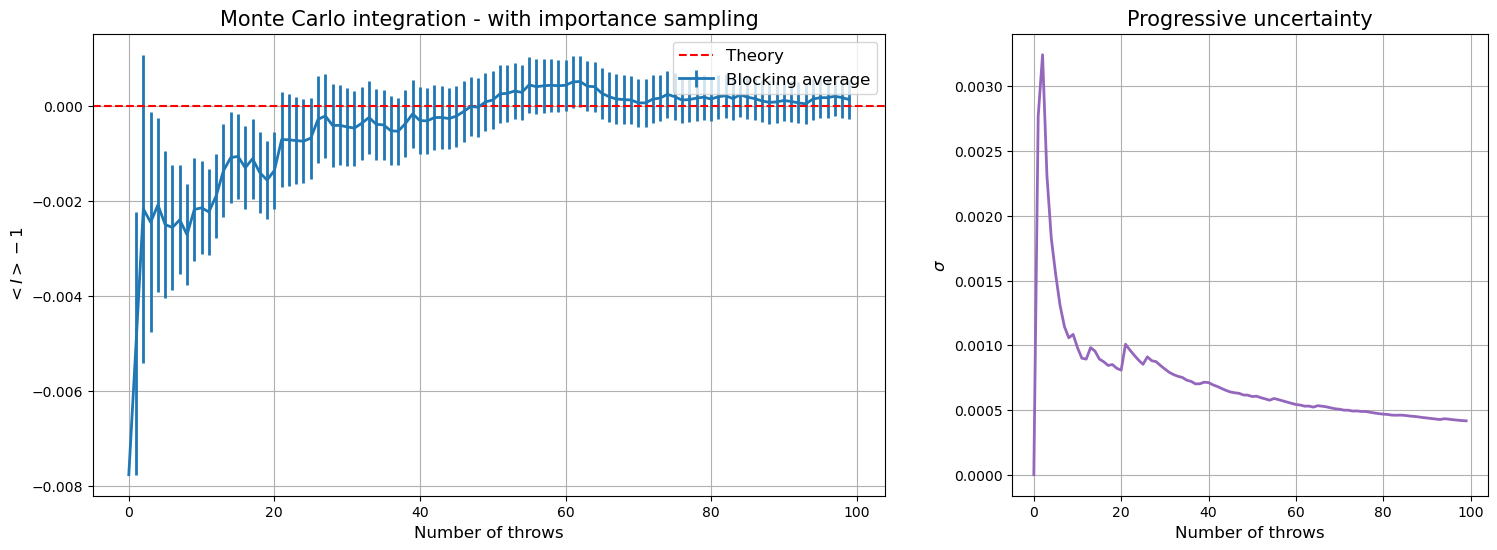

In [3]:
#importance sampling data
x_valueI, progressive_averageI, progressive_errorI = np.loadtxt('2.1/2.1.2.dat', unpack=True, usecols=(0, 1, 2))

# Create a figure with 2 subplots, using width ratios of [2, 1.3] for the subplots
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [2, 1.2]}, figsize=(18,6))

# Plot data in the first subplot
axs[0].errorbar(x_valueI, progressive_averageI-1, yerr=progressive_errorI,lw=2, label='Blocking average', c='tab:blue')
axs[0].grid(True)  # Add grid lines to the plot
axs[0].axhline(0, ls='--', c='red', label='Theory')  # Add a horizontal line at y=0 in red
axs[0].set_xlabel('Number of throws', fontsize=12)
axs[0].set_ylabel('$<I>-1$', fontsize=12)
axs[0].legend(fontsize=12)  # Add a legend to the plot
axs[0].set_title('Monte Carlo integration - with importance sampling', fontsize=15)

# Plot data in the second subplot
axs[1].plot(x_valueI, progressive_errorI,lw=2, c='tab:purple')
axs[1].grid(True)  # Add grid lines to the plot
axs[1].set_xlabel('Number of throws', fontsize=12)
axs[1].set_ylabel('$\sigma$', fontsize=12)
axs[1].set_title('Progressive uncertainty', fontsize=15)

# Show the plot
plt.show()

### Comparison 

Now we can compare the two methods by showing simultaneously the progressive blocking average and progressive error. The graphs show how importance sampling converges a lot faster and with an error that is significantly lower already at the first steps, ending with an error approximately $3.6$ times smaller than that obtained with the uniform distribution. 

Last value of Importance sampling error: 0.000416098
Last value of Uniform sampling error: 0.001511
Ratio of errors: 3.631356074770847


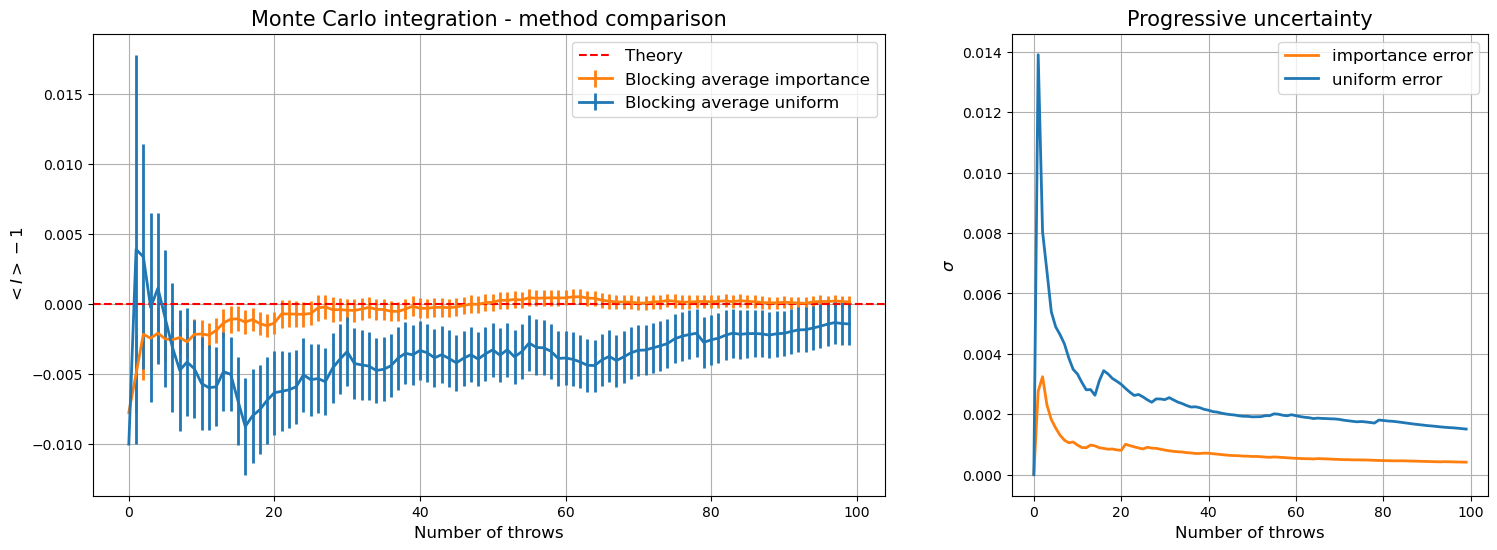

In [4]:
# methods comparison
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [2, 1.2]}, figsize=(18,6))

# Plot data in the first subplot
axs[0].errorbar(x_valueI, progressive_averageI-1, yerr=progressive_errorI,lw=2, label='Blocking average importance', c='tab:orange')
axs[0].errorbar(x_valueU, progressive_averageU-1, yerr=progressive_errorU,lw=2, label='Blocking average uniform', c='tab:blue')

axs[0].grid(True)  # Add grid lines to the plot
axs[0].axhline(0, ls='--', c='red', label='Theory')  # Add a horizontal line at y=0 in red
axs[0].set_xlabel('Number of throws', fontsize=12)
axs[0].set_ylabel('$<I>-1$', fontsize=12)
axs[0].legend(fontsize=12)  # Add a legend to the plot
axs[0].set_title('Monte Carlo integration - method comparison', fontsize=15)

# Plot data in the second subplot
axs[1].plot(x_valueI, progressive_errorI,lw=2, label='importance error', c='tab:orange')
axs[1].plot(x_valueU, progressive_errorU,lw=2, label='uniform error', c='tab:blue')

axs[1].grid(True)  # Add grid lines to the plot
axs[1].set_xlabel('Number of throws', fontsize=12)
axs[1].set_ylabel('$\sigma$', fontsize=12)
axs[1].legend(fontsize=12)  # Add a legend to the plot
axs[1].set_title('Progressive uncertainty', fontsize=15)

# Print the last value of progressive_errorI and progressive_errorU
print("Last value of Importance sampling error:", progressive_errorI[-1])
print("Last value of Uniform sampling error:", progressive_errorU[-1])
print("Ratio of errors:", progressive_errorU[-1]/progressive_errorI[-1])


# Show the plot
plt.show()


## 2.2

3D Random Walks (RW) on a cubic lattice and in the continuum: repeat many times (e.g. say $10^4$) the simulation of a random walk in 3D always starting at the origin.

1. on a cubic lattice with lattice constant $a=1$; at each discrete time the walker makes a forward or backward step of length equal to $a$ in one of the 3 principal directions of the lattice: $x$, $y$ or $z$
2. in the continuum; at each discrete time the walker makes a step of length equal to $a(=1)$ along a **random direction** obtained by sampling **uniformly** the solid angle: $\theta \in [0,\pi]$ and $\phi \in [0,2\pi]$

Show a picture of $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ for both RWs, with their statistical uncertainties, as function of the step $i\in [0,10^2]$.

Suggestion: divide your $M$ throws into a reasonable number of blocks, compute $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ as function of the step $i\in [0,10^2]$ in each block and use these values (for fixed $i$) to obtain the average value and its statistical uncertainty.

Note that you could try to fit both results with a function like $f(N)=k\sqrt{N}$. Do your results indicate a diffusive behavior?

## Solution

This exercise implements the simulation of a Random Walk, which is a mathematical formalisation of the trajectory drawn by taking successive random steps. Our version of the random walk makes several assumptions. In fact all steps have a fixed length, making each step confined to moving on the surface of a sphere of a certain radius from the starting point. The walk on the cubic lattice and in the continuum differ slightly in the possibility of movement as I will explain later. 

Formulating the 1D Random Walk on a lattice as a _Markov process_ allows us to define the probability to find the particle in consideration at point $x$ in a given time $t$ using two equal transition probabilities to the neighboring sites and observe how the process satisfies a differential equation for the probability $p(x,t)$
$$ \frac{\partial p(x,t)}{\partial t} = D \frac{\partial^2 p(x,t)}{\partial x^2} $$
which is a _diffusion equation_ for our probability with $D=a^2/2\tau$, $a$ being the step size and $\tau$ the time between steps. 
<br> The exercise will attempt to verify this diffusive behaviour. In fact, if the simulation starts at the origin, i.e. $p(x,t=0)=\delta(x)$, the probability comes out being
$$ p(x,t) = \frac{1}{\sqrt{4\pi Dt}} \exp{\frac{-x^2}{4Dt}} $$
which is a normal distribution centered in $x=0$ with variance $\sigma^2=2Dt$. 

Now in our case we will be taking steps with $t=N\tau$, i.e. all spaced equally, thus obtaining $\sigma^2=2(a^2/2\tau)N\tau=Na^2$, then $\sigma = a \sqrt N $ which gives the law of the fit we wish to observe. 

**Is this true? how does this say anything about the distance?** 

Both the random walk on the lattice and in the continuum were simulated in the same `main.cpp` file under the dir `./2.2` and the general approach was the same for both. 
<br> In order to keep track of the 3D positions I initialized a 2D array where within a row I had the 3 doubles for the $x$, $y$ and $z$ components of the position, and in column I had a number of these positions equal to the `iterations` I wanted to run for the simulation. Thus I could increment one by one all `iterations`$=10^4$ positions, taking one step at a time and then save the progressive distance for each step and each iterations. In order to do block averaging, the iterations where as always divided into `blocks` each of size `blockSize`. The distance was calculated from the origin with a simple function `modulusSquared` which allowed to find the modulus squared of a vector of any size.

### Random walk on a cubic lattice

Now to directly address how we can simulate a random step taken back or forth in any of the 3 directions, which my code implements in the function `latticeStep`:
```cpp
int deg = floor(rnd.Rannyu(0,6)) ;
int dir = floor(deg/2.);
vec[dir] += step_length*pow(-1.,deg); 
`````
Here one of the 6 degrees of freedom (forward or backward for each direction) is picked at random and saved in the variable `deg`. This is done by generating uniformly at random in $(0,6)$ and then taking the floor of the pick. Here the range $(0,1)$ gives `deg=0` and represents a step forward along $x$ direction, $(1,2)$ gives `deg=2`, backward in the $x$ direction and so forth. Now to extrapolate the direction, we took the floor of half the variable `deg`, which allowed the range $(0,2)$ all the give `dir=0` and be used as parameter to modify the vector. Finally, to decide whether to go forward or backward, I multiplied the `step_length` by $-1^{deg}$ so that even values of `deg` would give a step forward and odd values a step backward.

Inside the main part of the simulation where each step is taken, the code loops over the number of iterations and passes the position array with fixed column (i.e. the i-th iteration position) to the function `latticeWalk` which simply loops over a fixed number of lattice steps. This number was fixed to 1 step in order to save information for each successive step. 

The graph below shows the average value (among iterations and through block averaging) of the distance from the origin of the particle position at each step taken from $1$ to `maxSteps`$=100$. The points where fitted with a function of type $f(x)=a\sqrt x $ with $a$ being the only fit parameter. As expected, the fit gave $a$ pretty close to $1$ which was the parameter chosen for the lattice constant spacing. This confirms the diffusive behaviour of the random walk, which I checked also varying the step length.

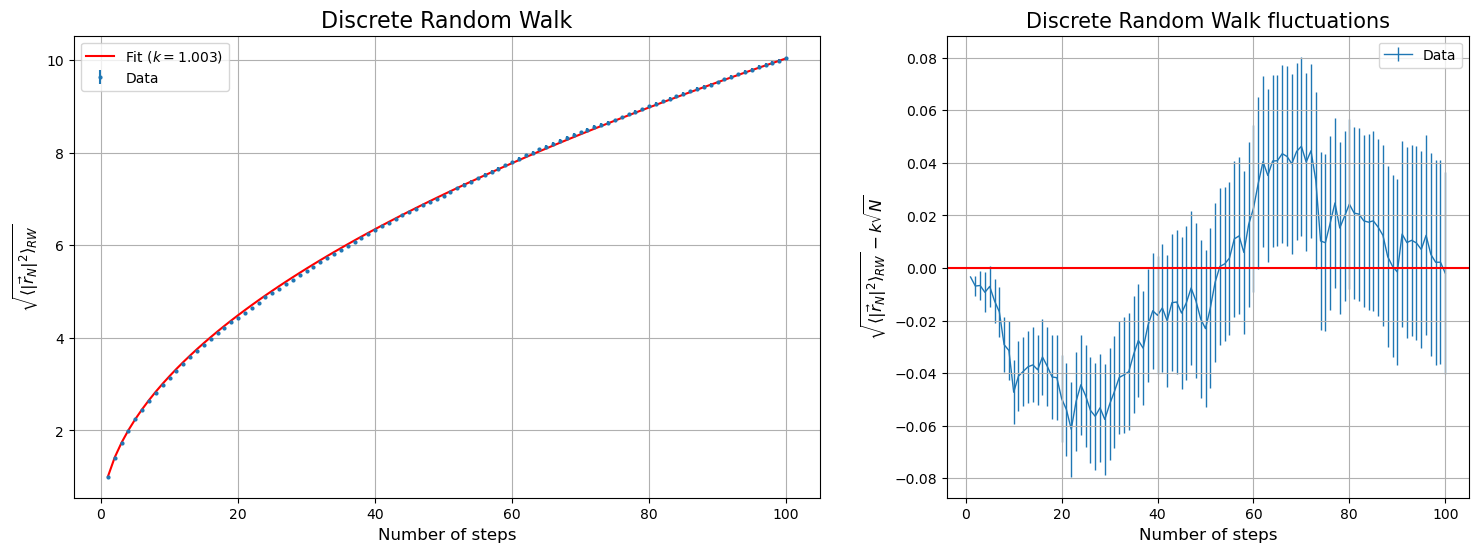

In [5]:
# discrete RW
stepD, progressive_averageD, progressive_errorD = np.loadtxt('2.2/2.2.1.dat', unpack=True, usecols=(0, 1, 2))

# Define fit to be used
def fit_function(x, a):
   return a * np.sqrt(x)

# Create a figure with 2 subplots, using width ratios of [2, 1.3] for the subplots
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1, 0.7]}, figsize=(18,6))

# Plot data in the first subplot
axs[0].errorbar(stepD, progressive_averageD, progressive_errorD,
                linestyle = " ", marker = "o", label = 'Data', markersize = 2)
axs[0].grid(True)  # Add grid lines to the plot
#fit
params_discr = curve_fit (fit_function, stepD, progressive_averageD)
lab ='Fit ($k=$' + str(round(params_discr[0][0], 3)) + ')'
axs[0].plot(stepD, fit_function(stepD, params_discr[0]), label = lab, color = "red")
# style first subplot
axs[0].set_xlabel('Number of steps', fontsize=12)
axs[0].set_ylabel(r'$\sqrt{\langle|\vec{r}_N|^2 \rangle_{RW} }$', fontsize=12)
# axs[0].set_xlim(90,100)
# axs[0].set_ylim(9,11)
axs[0].legend()
axs[0].set_title('Discrete Random Walk', fontsize=16)

# Plot data in the second subplot
axs[1].set_title(r'Discrete Random Walk fluctuations', size = 15)
axs[1].errorbar(stepD, progressive_averageD - fit_function(stepD, params_discr[0]), yerr = progressive_errorD,  
            zorder = 1, label = 'Data', lw = 1)
# style second subplot
axs[1].axhline(0, color = 'red')
axs[1].set_xlabel('Number of steps', size = 12)
axs[1].set_ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}} - k\sqrt{N}$', size = 12)
axs[1].legend()
axs[1].grid(True)

# Show the plot
plt.show()

### Random Walk on the continuum

#### Sampling the sphere
Sampling points at random on the unit sphere is surprisingly not as straight forward as one would expect. I learned this trying the incorrect method for the first simulation and noticing a persistent deviation from the expect value of $\pi$ in the _Buffon's experiment_. At first I hyphotized some mistake in the inversion of distributions that I was using, but curiosity lead me to research the problem and find interesting aspects that I will breefly summarize.
<br> The approach I took at first, mistakenly, was this. We could be tempted to draw two angles, the polar angle $\theta \in [0,\pi]$ and the azimuthal angle $\phi \in [0,2\pi]$ and convert them to cartesian coordinates with the usual conversion, thus having obtained a point on the sphere. However, this does not sample uniformly the unit sphere, but rather concentrates its picks around the poles, leaving the equator quite bare. 
<br> After this discovery, during the second Lecture we were illustrated a method to correctly draw an angle in $[0,2\pi]$ which I then coded as a method of the random class `double Random :: Theta()`:
````cpp
double a = Rannyu(-1., 1.);
double b = Rannyu(-1., 1.);
if (b==0){
	return 0;
}
double x = acos(a/sqrt(pow(a,2)+pow(b,2))) ;
if (pow(a,2)+pow(b,2) < 1){
	if (b >= 0) return x ; 
	else return 2*M_PI - x ;
}
else{
	return Theta();
}
````
Thus to sample the sphere, two angles were drawn using this method and then through spherical to cartesian coordinates conversion, the point on the sphere was obtained.
Below a visual representation of this method, which clearly samples uniformly the sphere, alongside the incorrect sampling done drawing the two angles uniformly, $\theta \in [0,\pi]$ and $\phi \in [0,2\pi]$ which shows an oversampling of the poles.

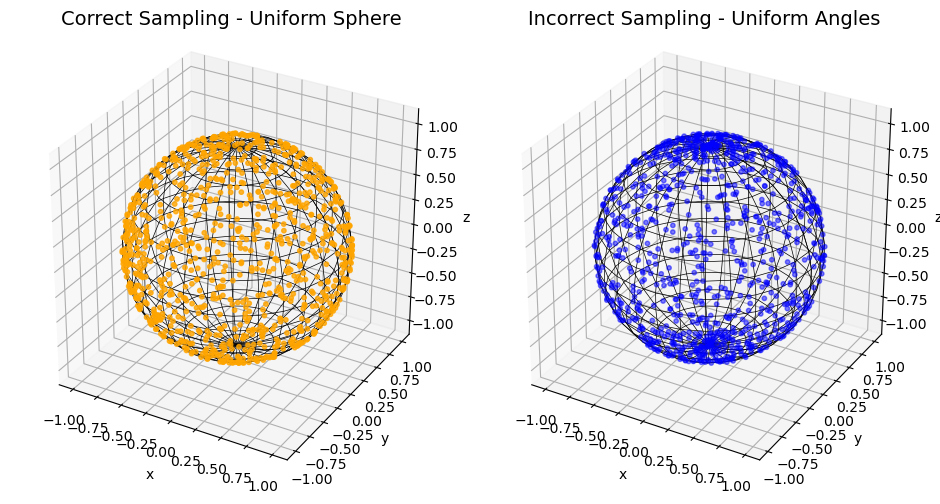

In [6]:
# sphere sampling visualization

import math  # For arccos function

# Create a new figure with a specific aspect ratio
fig = plt.figure(figsize=plt.figaspect(0.5))

# Create a wireframe for the unit sphere
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
xx = np.cos(u) * np.sin(v)  # X-coordinates of the unit sphere
yy = np.sin(u) * np.sin(v)  # Y-coordinates
zz = np.cos(v)  # Z-coordinates

# Function to generate a uniform angle (0, 2*pi) based on sampling within a unit circle
def uniform_phi():
    while True:
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        if x**2 + y**2 <= 1:  # Check if within the unit circle
            if y >= 0:
                return np.arccos(x / np.sqrt(x**2 + y**2))  # Angle in (0, pi)
            else:
                return 2 * np.pi - np.arccos(x / np.sqrt(x**2 + y**2))  # Angle in (pi, 2*pi)

# Number of points to generate
num_points = 1000

# Correct sampling with uniform phi
phi = np.array([uniform_phi() for _ in range(num_points)])  # Azimuthal angle
z = np.random.uniform(-1, 1, num_points)  # Polar angle from -1 to 1
theta = np.arccos(z)  # Convert z to polar angle

# Cartesian coordinates
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

# Plot the scatter plot for uniformly sampled points on the unit sphere
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_title('Correct Sampling - Uniform Sphere', size=14)
ax1.scatter(x, y, z, s=10, c="orange", alpha=0.8)  # Scatter plot for the points
ax1.plot_wireframe(xx, yy, zz, lw=0.5, color="black")  # Add the unit sphere wireframe
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.set_box_aspect([1, 1, 1])  # Maintain cubic aspect ratio

# Incorrect sampling method for comparison
theta_incorrect = np.random.uniform(0, np.pi, num_points)  # Uniformly drawn polar angle
phi_incorrect = np.random.uniform(0, 2 * np.pi, num_points)  # Uniformly drawn azimuthal angle

x_incorrect = np.sin(theta_incorrect) * np.cos(phi_incorrect)
y_incorrect = np.sin(theta_incorrect) * np.sin(phi_incorrect)
z_incorrect = np.cos(theta_incorrect)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # Add a second subplot for incorrect sampling
ax2.set_title('Incorrect Sampling - Uniform Angles', size=14)
ax2.scatter(x_incorrect, y_incorrect, z_incorrect, s=10, c="blue", alpha=0.5)  # Scatter plot for points with incorrect distribution
ax2.plot_wireframe(xx, yy, zz, lw=0.5, color="black")  # Add the unit sphere wireframe
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
ax2.set_box_aspect([1, 1, 1])  # Maintain cubic aspect ratio

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()  # Display the plots


The articles that I used for reference on sampling the unit sphere:
- [Mathemathinking, Generating uniformly distributed numbers on a sphere](http://corysimon.github.io/articles/uniformdistn-on-sphere/)
- [Wolfram MathWorld, Sphere Point Picking](https://mathworld.wolfram.com/SpherePointPicking.html)

#### Implementation

The implementation of the 3D continuum random walk was at this point readily achieved. Similarly to what the above python snippet does, using the function `Random :: Theta()`, my code generates the two angles and then converts them to cartesian coordinates using a radius the step length, fixed once again to $1$. This allows me to increment all the positions for all `iterations` one at a time for each step, in order to then calculate the distance from the origin and do block averaging. 

The graphs below show again the average value of the distance from the origin of the particle position at each step taken from $1$ to `maxSteps`$=100$. The points where fitted with $f(x)=a\sqrt x $. As expected, the fit gave $a$ pretty close to $1$ which was the parameter chosen for the step length.

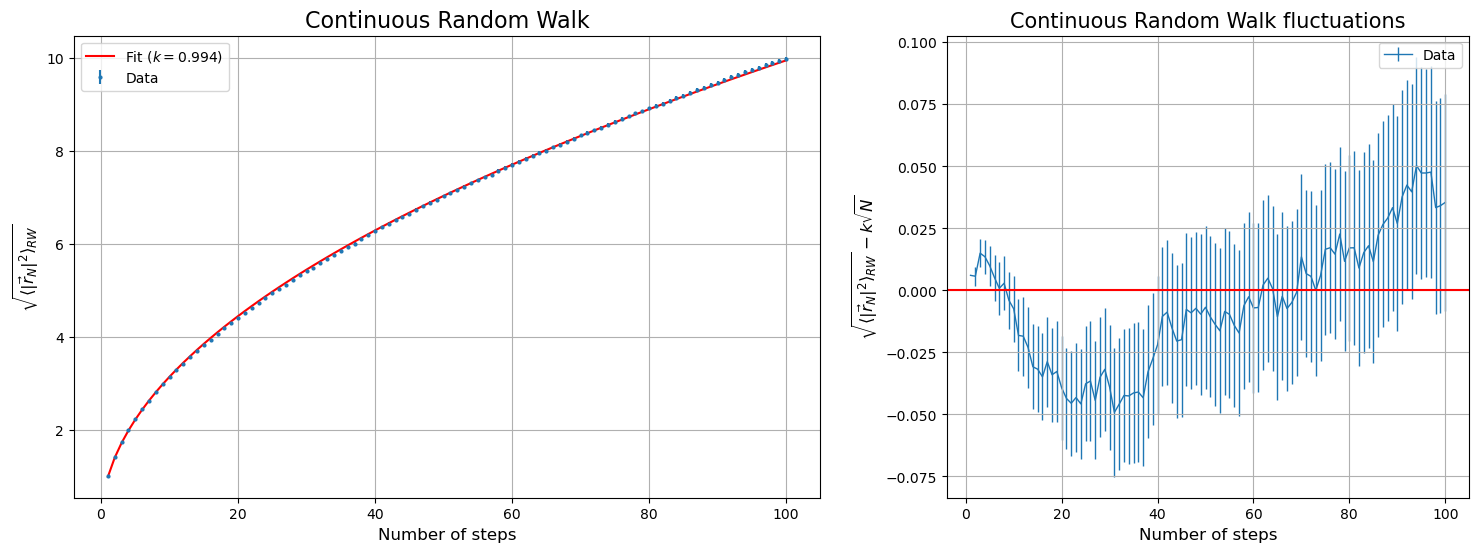

In [7]:
# continuum RW
stepC, progressive_averageC, progressive_errorC = np.loadtxt('2.2/2.2.2.dat', unpack=True, usecols=(0, 1, 2))

# Define fit to be used
def fit_function(x, a):
   return a * np.sqrt(x)

# Create a figure with 2 subplots, using width ratios of [2, 1.3] for the subplots
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1, 0.7]}, figsize=(18,6))

# Plot data in the first subplot
axs[0].errorbar(stepC, progressive_averageC, progressive_errorC,
                linestyle = " ", marker = "o", label = 'Data', markersize = 2)
axs[0].grid(True)  # Add grid lines to the plot
#fit
params_discr = curve_fit (fit_function, stepC, progressive_averageC)
lab ='Fit ($k=$' + str(round(params_discr[0][0], 3)) + ')'
axs[0].plot(stepC, fit_function(stepC, params_discr[0]), label = lab, color = "red")
# style first subplit
axs[0].set_xlabel('Number of steps', fontsize=12)
axs[0].set_ylabel(r'$\sqrt{\langle|\vec{r}_N|^2 \rangle_{RW} }$', fontsize=12)
# axs[0].set_xlim(90,100)
# axs[0].set_ylim(9,11)
axs[0].legend()
axs[0].set_title('Continuous Random Walk', fontsize=16)

# Plot data in the second subplot
axs[1].set_title(r'Continuous Random Walk fluctuations', size = 15)
axs[1].errorbar(stepC, progressive_averageC - fit_function(stepC, params_discr[0]), yerr = progressive_errorC,  
            zorder = 1, label = 'Data', lw = 1)
# style second subplot
axs[1].axhline(0, color = 'red')
axs[1].set_xlabel('Number of steps', size = 12)
axs[1].set_ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}} - k\sqrt{N}$', size = 12)
axs[1].legend()
axs[1].grid(True)

# Show the plot
plt.show()

Finally, something interesting comes out with the errors, since they too present some kind of diffusive behaviour, like illustrated below. What could the constan of $0.004$ be?

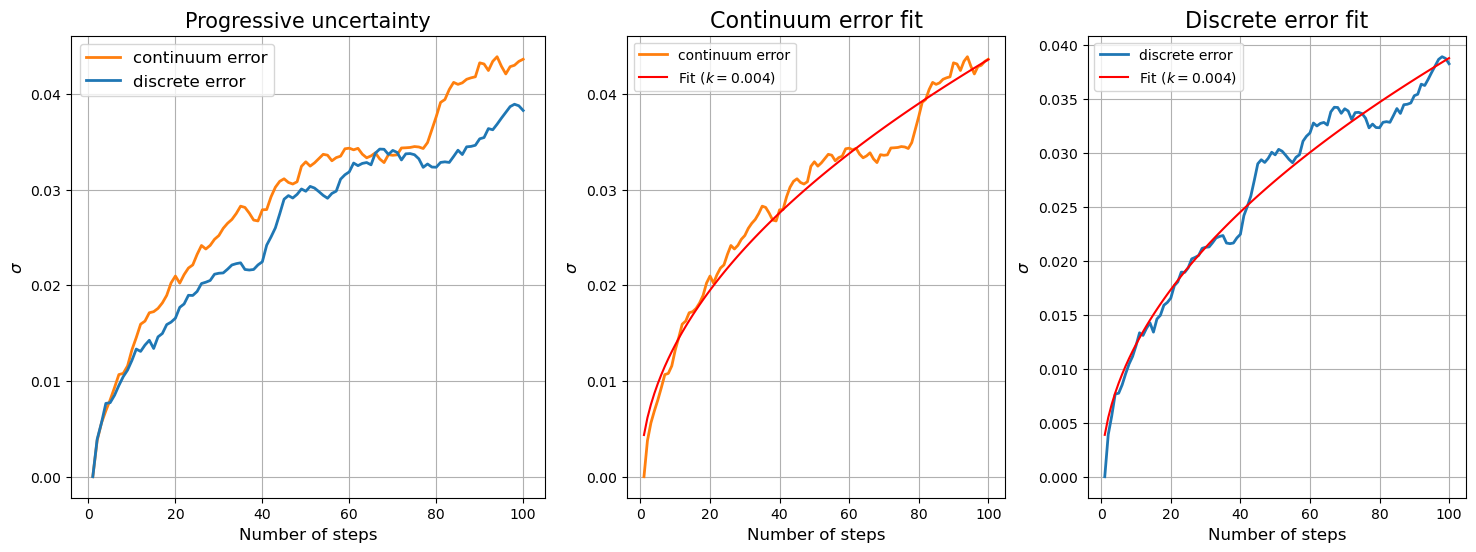

In [8]:

# Create a figure with 2 subplots, using width ratios of [2, 1.3] for the subplots
fig, axs = plt.subplots(ncols=3, gridspec_kw={'width_ratios': [1, 0.8, 0.8]}, figsize=(18,6))


# error comparison
axs[0].plot(stepC, progressive_errorC,lw=2, label='continuum error', c='tab:orange')
axs[0].plot(stepD, progressive_errorD,lw=2, label='discrete error', c='tab:blue')
axs[0].grid(True)  # Add grid lines to the plot
axs[0].set_xlabel('Number of steps', fontsize=12)
axs[0].set_ylabel('$\sigma$', fontsize=12)
axs[0].legend(fontsize=12)  # Add a legend to the plot
axs[0].set_title('Progressive uncertainty', fontsize=15)


# Define fit to be used
def fit_function(x, a):
   return a * np.sqrt(x)

#fit continuum
params_discrC = curve_fit (fit_function, stepC, progressive_errorC)
lab ='Fit ($k=$' + str(round(params_discrC[0][0], 3)) + ')'
axs[1].plot(stepC, progressive_errorC,lw=2, label='continuum error', c='tab:orange')
axs[1].plot(stepC, fit_function(stepC, params_discrC[0]), label = lab, color = "red")
axs[1].grid(True)  # Add grid lines to the plot
axs[1].set_xlabel('Number of steps', fontsize=12)
axs[1].set_ylabel('$\sigma$', fontsize=12)
axs[1].legend()
axs[1].set_title('Continuum error fit', fontsize=16)

# fit discrete
params_discrD = curve_fit (fit_function, stepD, progressive_errorD)
lab ='Fit ($k=$' + str(round(params_discrD[0][0], 3)) + ')'
axs[2].plot(stepD, progressive_errorD,lw=2, label='discrete error', c='tab:blue')
axs[2].plot(stepD, fit_function(stepC, params_discrD[0]), label = lab, color = "red")
axs[2].grid(True)  # Add grid lines to the plot
axs[2].set_xlabel('Number of steps', fontsize=12)
axs[2].set_ylabel('$\sigma$', fontsize=12)
axs[2].legend()
axs[2].set_title('Discrete error fit', fontsize=16)


plt.show()

### Random walk visualization

I thought interesting to see how the random walk actually moved in 3D space. For this reason I took one of the simulations a bit further, totaling $5000% steps, both in the continuum and on the lattice, and used a function that progressively saved the coordinates. Below are a visual representation of the Random Walks and the first 100 steps which where the ones examined above.

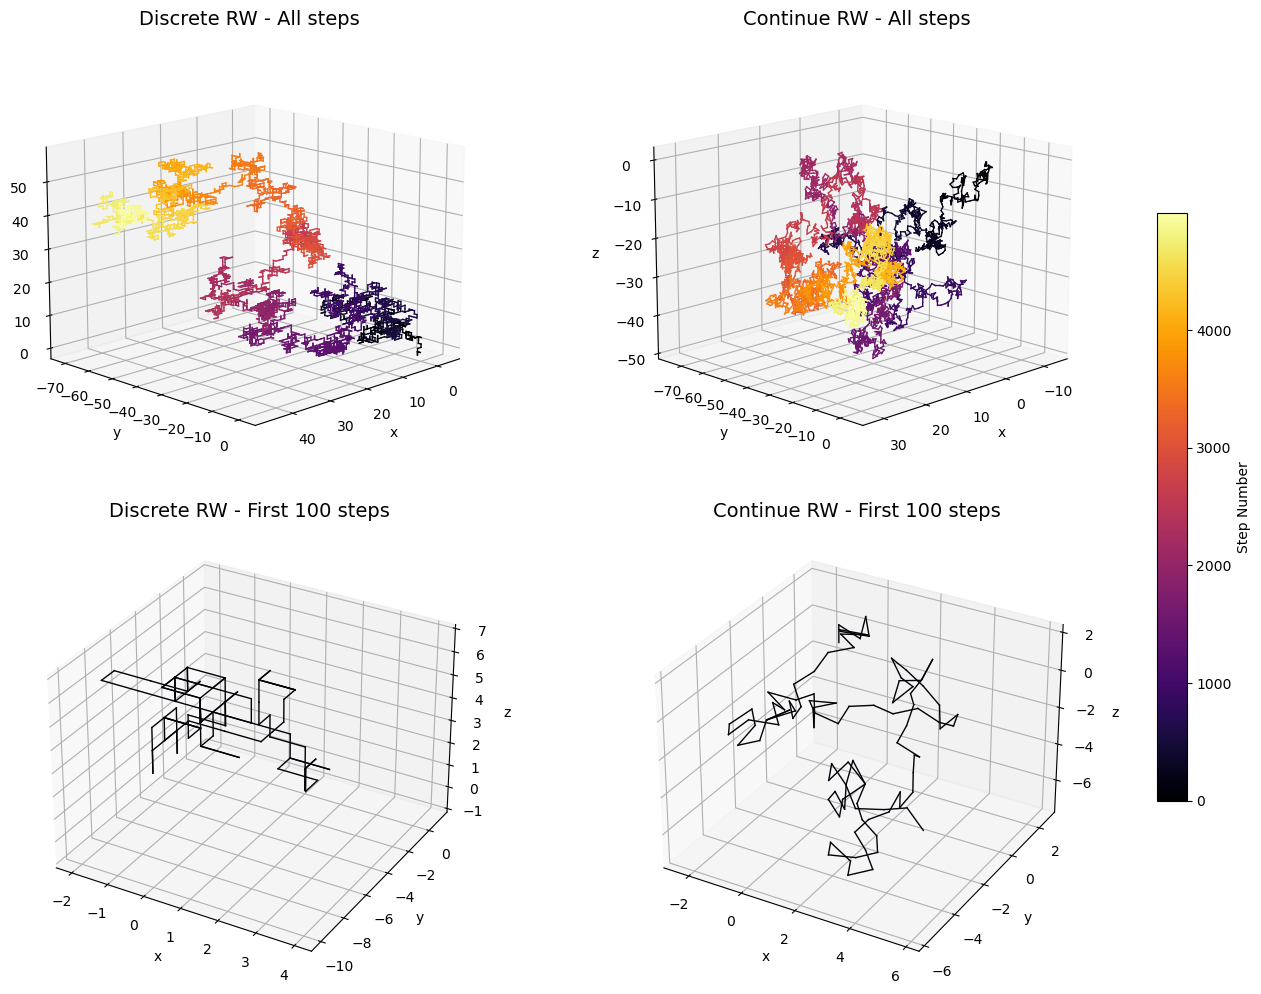

In [9]:
# Data acquisition for all four plots
x_d, y_d, z_d = np.loadtxt('./2.2/2.2.1_positions.dat', usecols=(1, 2, 3), unpack=True)
x_c, y_c, z_c = np.loadtxt('./2.2/2.2.2_positions.dat', usecols=(1, 2, 3), unpack=True)

# Create a 2x2 grid of subplots in the same figure
fig, axs = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': '3d'}, figsize=(15, 10))

# Create a color map to represent the gradient based on step numbers
norm = mcolors.Normalize(vmin=0, vmax=len(x_d))
cmap = plt.colormaps.get_cmap('inferno')  # Updated colormap method to avoid deprecation warning

# Function to plot a 3D line with a color gradient
def plot_gradient_line(ax, x, y, z, cmap, norm):
    for i in range(1, len(x)):
        ax.plot([x[i - 1], x[i]], [y[i - 1], y[i]], [z[i - 1], z[i]], color=cmap(norm(i)), lw=1)

# Plot 1: Discrete RW - All steps with gradient
plot_gradient_line(axs[0, 0], x_d, y_d, z_d, cmap, norm)
axs[0, 0].set_title('Discrete RW - All steps', size=14)
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_zlabel("z")
axs[0, 0].view_init(elev=15, azim=45)

# Plot 2: Continue RW - All steps with gradient
plot_gradient_line(axs[0, 1], x_c, y_c, z_c, cmap, norm)
axs[0, 1].set_title('Continue RW - All steps', size=14)
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_zlabel("z")
axs[0, 1].view_init(elev=15, azim=45)

# Plot 3: Discrete RW - First 100 steps with gradient
plot_gradient_line(axs[1, 0], x_d[:100], y_d[:100], z_d[:100], cmap, norm)
axs[1, 0].set_title('Discrete RW - First 100 steps', size=14)
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("y")
axs[1, 0].set_zlabel("z")

# Plot 4: Continue RW - First 100 steps with gradient
plot_gradient_line(axs[1, 1], x_c[:100], y_c[:100], z_c[:100], cmap, norm)
axs[1, 1].set_title('Continue RW - First 100 steps', size=14)
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("y")
axs[1, 1].set_zlabel("z")

# Adjust spacing between subplots to avoid overlapping titles/labels
plt.tight_layout()

# Add a color bar to represent the gradient based on step numbers
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array for color bar
fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.05, label='Step Number')

# Show the plots
plt.show()
